# Mutiple Choice

## Description

- what is:&nbsp;Mutiple Choice actually is a type of MRC task, but different form the "frangment exrtraction",
the answers will be given and model's task is to choose correct answer/answers

- data:&nbsp;in the mutiple choices task, we usually give one/some docs for the "context" and give a question Q and mutiple possible answers A, output "A" for answers 

- generationally speak:&nbsp;the mutiple choice not just a mrc task, it can be thought to a kind of "context matching", becasue the answer is another docs given, not extracted from oringal context

## Treantment Strategy

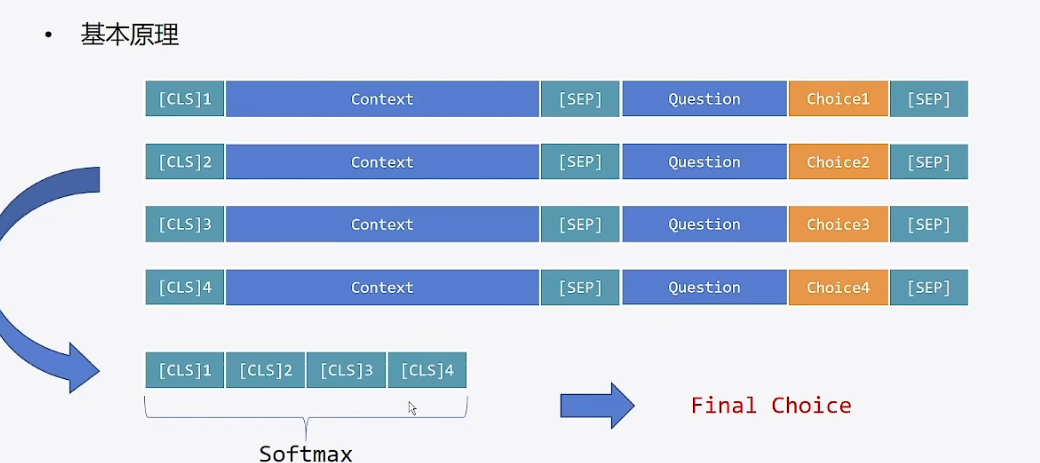

- in the model config, it basically set the classifier for the every choice, but this can not show witch one is better than others, so after the basic classifier, extract their [CLS] to do softmax,\
then the softmax could compute the distribution of these choices and pick one or more

- in the model's config, the base model is 'bert', and then deal with the dimentions of data, last output is a shape of (batch, num_choice), and then softmax the 'num_choice' dimention 

In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [1]:
import evaluate
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForMultipleChoice, TrainingArguments, Trainer, pipeline
import numpy as np
import torch
from typing import Any

In [2]:
data = DatasetDict.load_from_disk('./c3')
print(data)
print(data['train'][:3])
print(data['test'][0])
print(data['train'].features)

DatasetDict({
    test: Dataset({
        features: ['id', 'context', 'question', 'choice', 'answer'],
        num_rows: 1625
    })
    train: Dataset({
        features: ['id', 'context', 'question', 'choice', 'answer'],
        num_rows: 11869
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'choice', 'answer'],
        num_rows: 3816
    })
})
{'id': [0, 1, 2], 'context': [['男：你今天晚上有时间吗?我们一起去看电影吧?', '女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……'], ['男：足球比赛是明天上午八点开始吧?', '女：因为天气不好，比赛改到后天下午三点了。'], ['女：今天下午的讨论会开得怎么样?', '男：我觉得发言的人太少了。']], 'question': ['女的最喜欢哪种电影?', '根据对话，可以知道什么?', '关于这次讨论会，我们可以知道什么?'], 'choice': [['恐怖片', '爱情片', '喜剧片', '科幻片'], ['今天天气不好', '比赛时间变了', '校长忘了时间'], ['会是昨天开的', '男的没有参加', '讨论得不热烈', '参加的人很少']], 'answer': ['喜剧片', '比赛时间变了', '讨论得不热烈']}
{'id': 0, 'context': ['老师把一个大玻璃瓶子带到学校，瓶子里装着满满的石头、玻璃碎片和沙子。之后，老师请学生把瓶子里的东西都倒出来，然后再装进去，先从沙子开始。每个学生都试了试，最后都发现没有足够的空间装所有的石头。老师指导学生重新装这个瓶子。这次，先从石头开始，最后再装沙子。石头装进去后，沙子就沉积在石头的周围，最后，所有东西都装进瓶子里了。老师说：“如果我们先从小的东西开始，把小东西装进去之后，大的石头

In [3]:
data.pop('test')
data

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'choice', 'answer'],
        num_rows: 11869
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'choice', 'answer'],
        num_rows: 3816
    })
})

In [4]:
tokenizer = AutoTokenizer.from_pretrained('./macbert-base-chinese')
tokenizer

BertTokenizerFast(name_or_path='./macbert-base-chinese', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [5]:
sample = data['train'][0]
context = []
Q_A = []
labels = []

choices = sample['choice']

for choice in choices:
    ctx = '\n'.join(sample['context'])
    context.append(ctx)
    Q_A.append(sample['question']+" "+choice)
labels.append(choices.index(sample['answer']))

tokenized_sample = tokenizer(text=context, text_pair=Q_A, truncation='only_first', max_length=256, padding='max_length')
tokenized_sample

{'input_ids': [[101, 4511, 8038, 872, 791, 1921, 3241, 677, 3300, 3198, 7313, 1408, 136, 2769, 812, 671, 6629, 1343, 4692, 4510, 2512, 1416, 136, 1957, 8038, 872, 1599, 3614, 2607, 2587, 4275, 1469, 4263, 2658, 4275, 8024, 852, 3221, 2769, 1599, 3614, 1599, 1196, 4275, 8024, 4906, 2404, 4275, 671, 5663, 511, 2792, 809, 100, 100, 102, 1957, 4638, 3297, 1599, 3614, 1525, 4905, 4510, 2512, 136, 2607, 2587, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4511, 8038, 872, 

In [6]:
for k,v in tokenized_sample.items():
    print(k,v)
    print("---------------------")
    print(len(v))

input_ids [[101, 4511, 8038, 872, 791, 1921, 3241, 677, 3300, 3198, 7313, 1408, 136, 2769, 812, 671, 6629, 1343, 4692, 4510, 2512, 1416, 136, 1957, 8038, 872, 1599, 3614, 2607, 2587, 4275, 1469, 4263, 2658, 4275, 8024, 852, 3221, 2769, 1599, 3614, 1599, 1196, 4275, 8024, 4906, 2404, 4275, 671, 5663, 511, 2792, 809, 100, 100, 102, 1957, 4638, 3297, 1599, 3614, 1525, 4905, 4510, 2512, 136, 2607, 2587, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4511, 8038, 872, 791,

In [17]:
tokenized_sample.items()

dict_items([('input_ids', [[101, 4511, 8038, 872, 791, 1921, 3241, 677, 3300, 3198, 7313, 1408, 136, 2769, 812, 671, 6629, 1343, 4692, 4510, 2512, 1416, 136, 1957, 8038, 872, 1599, 3614, 2607, 2587, 4275, 1469, 4263, 2658, 4275, 8024, 852, 3221, 2769, 1599, 3614, 1599, 1196, 4275, 8024, 4906, 2404, 4275, 671, 5663, 511, 2792, 809, 100, 100, 102, 1957, 4638, 3297, 1599, 3614, 1525, 4905, 4510, 2512, 136, 2607, 2587, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4511,

In [22]:
tokenized_sample = {k: [v[i:i+4] for i in range(0, len(v), 4)] for k, v in tokenized_sample.items()}
print(tokenized_sample)

{'input_ids': [[[101, 4511, 8038, 872, 791, 1921, 3241, 677, 3300, 3198, 7313, 1408, 136, 2769, 812, 671, 6629, 1343, 4692, 4510, 2512, 1416, 136, 1957, 8038, 872, 1599, 3614, 2607, 2587, 4275, 1469, 4263, 2658, 4275, 8024, 852, 3221, 2769, 1599, 3614, 1599, 1196, 4275, 8024, 4906, 2404, 4275, 671, 5663, 511, 2792, 809, 100, 100, 102, 1957, 4638, 3297, 1599, 3614, 1525, 4905, 4510, 2512, 136, 2607, 2587, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4511, 8038, 872,

In [7]:
def preprocess_func(example, tokenizer=tokenizer):
    context = []
    Q_A = []
    labels = []

    for idx in range(len(example['context'])):
        ctx = '\n'.join(example['context'][idx]) # context might be a conversation witch has two strings
        question = example['question'][idx]
        answer = example['answer'][idx]
        choices = example['choice'][idx]
        for choice in choices:
            context.append(ctx)
            Q_A.append(question+":"+choice)
        if len(choices) < 4:
            for _ in range(4-len(choices)):
                context.append(ctx)
                Q_A.append(question+":"+"无该选项")
        labels.append(choices.index(answer)) # store id index but not string

    tokenized_example = tokenizer(text=context, 
                                  text_pair=Q_A, 
                                  truncation='only_first',
                                  max_length=256,
                                  padding='max_length')
    # input shape [example_nums*num_choices, 512] to
    # legal input shape: tensor [example_nums, num_choice, 512]
    tokenized_example = {k: [v[i:i+4] for i in range(0,len(v),4)] for k, v in tokenized_example.items()}
    tokenized_example['labels'] = labels

    return tokenized_example

In [8]:
tokenized_data = data.map(preprocess_func, batched=True, remove_columns=data['train'].column_names)
print(tokenized_data)
print(tokenized_data['train'][0])

Map:   0%|          | 0/11869 [00:00<?, ? examples/s]

Map:   0%|          | 0/3816 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11869
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3816
    })
})
{'input_ids': [[101, 4511, 8038, 872, 791, 1921, 3241, 677, 3300, 3198, 7313, 1408, 136, 2769, 812, 671, 6629, 1343, 4692, 4510, 2512, 1416, 136, 1957, 8038, 872, 1599, 3614, 2607, 2587, 4275, 1469, 4263, 2658, 4275, 8024, 852, 3221, 2769, 1599, 3614, 1599, 1196, 4275, 8024, 4906, 2404, 4275, 671, 5663, 511, 2792, 809, 100, 100, 102, 1957, 4638, 3297, 1599, 3614, 1525, 4905, 4510, 2512, 136, 131, 2607, 2587, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
print(np.array(tokenized_data['train']['input_ids']).shape)
# now the shape of input is fit to MultipleChoice model

(11869, 4, 256)


In [11]:
mut_model = AutoModelForMultipleChoice.from_pretrained('./macbert-base-chinese')
acc = evaluate.load('accuracy')

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at ./macbert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
mut_model.config

BertConfig {
  "_name_or_path": "./macbert-base-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

In [13]:
# eval for per all num_choices, cause the model final output is (batch, num_choices)
def eval_metric(pred):
    prediction, label = pred
    print('len of pre:',len(prediction))
    print("pred:",prediction)
    prediction = np.argmax(prediction, axis=-1)
    accuracy = acc.compute(predictions=prediction, references=label)

    return accuracy

In [14]:
train_arg = TrainingArguments(
            output_dir='./mut_model',
            save_strategy='epoch',
            save_total_limit=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            evaluation_strategy='epoch',
            load_best_model_at_end=True,
            logging_steps=100
)
train_arg

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_always_push=False,
hub_mo

In [15]:
trainer = Trainer(
        model=mut_model,
        args=train_arg,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['validation'],
        compute_metrics=eval_metric
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.967900,0.921208,0.606656
2,0.618900,0.992813,0.634434
3,0.320400,1.319989,0.632075


len of pre: 3816
pred: [[-2.9968286  -0.5841515  -0.8539715   0.01759448]
 [-2.0314398  -0.5371335  -3.4142323  -3.3940942 ]
 [-4.1003103  -4.7125278  -2.8471181   0.7830453 ]
 ...
 [-2.5814679  -3.2395682  -2.3854008  -2.1127415 ]
 [-2.6718273  -2.5576704  -2.1321855  -2.1858983 ]
 [-3.0618675  -2.8188524  -3.0548105  -2.8403265 ]]
len of pre: 3816
pred: [[-6.919762   -3.999006   -1.736256    0.25241995]
 [-3.174451   -0.99891394 -5.743876   -4.3869777 ]
 [-6.7085137  -6.9744534  -4.396605    1.4006628 ]
 ...
 [-2.6072612  -5.3521986  -3.477635   -2.5174322 ]
 [-4.0653963  -3.759079   -2.9273167  -2.4958014 ]
 [-5.6210313  -5.534471   -4.9744434  -5.5164437 ]]
len of pre: 3816
pred: [[-8.412058   -4.4911556  -4.0538144   2.7765899 ]
 [-5.489951   -2.7934375  -8.0078535  -6.8158264 ]
 [-8.26438    -8.45261    -7.249556    0.28585333]
 ...
 [-2.9955688  -6.5329375  -3.6500373  -2.8202198 ]
 [-4.9048414  -4.8670487  -3.9151335  -3.7691827 ]
 [-7.398394   -7.150745   -6.6905127  -7.267896

TrainOutput(global_step=2226, training_loss=0.6893020143191877, metrics={'train_runtime': 927.275, 'train_samples_per_second': 38.4, 'train_steps_per_second': 2.401, 'total_flos': 1.873702246273229e+16, 'train_loss': 0.6893020143191877, 'epoch': 3.0})

In [43]:
from typing import Any

class MultipleChoicePipeline:

    def __init__(self, model, tokenizer) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device
        
    # input data preprocess
    def preprocess(self, context, question, choices):
        contexts = []
        question_choice = []
        for choice in choices:
            contexts.append(context)
            question_choice.append(question+":"+choice) # don't need to shape [batch, num_choice, length] cause prediction no "batch"
        return tokenizer(contexts, question_choice, truncation='only_first', max_length=256, padding=True, return_tensors='pt')
        
    # get logits prediction
    def predict(self, inputs):
        inputs = {k: v.unsqueeze(0).to(self.device) for k, v in inputs.items()} # to GPU reference
        logits = self.model(**inputs).logits
        return logits
    
    # decode
    def postprocess(self, logits, choices):
        prediction = torch.argmax(logits, dim=-1).cpu().item()
        return choices[prediction]

    def __call__(self, context, question, choices) -> Any:
        inputs = self.preprocess(context, question, choices)
        logits = self.predict(inputs)
        result = self.postprocess(logits, choices)
        return result

In [44]:
pipe = MultipleChoicePipeline(model=mut_model, tokenizer=tokenizer)

pipe('你在家里玩原神吗？原神，启动！', '你在玩什么？', ['原神', '塞尔达', '英雄联盟', '王者荣耀'])

'原神'